In [1]:
!pip install -q pycuda

     |████████████████████████████████| 1.7 MB 19.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 71 kB 10.8 MB/s 


In [14]:
import numpy as np
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time
from functools import partial
import matplotlib.pyplot as plt

In [2]:
!wget https://kartinkof.club/uploads/posts/2022-03/1648262508_27-kartinkof-club-p-matematik-mem-31.jpg -O image.jpg

--2022-12-08 20:28:04--  https://kartinkof.club/uploads/posts/2022-03/1648262508_27-kartinkof-club-p-matematik-mem-31.jpg
Resolving kartinkof.club (kartinkof.club)... 148.72.144.104
Connecting to kartinkof.club (kartinkof.club)|148.72.144.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129576 (127K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 126.54K   254KB/s    in 0.5s    

2022-12-08 20:28:06 (254 KB/s) - ‘image.jpg’ saved [129576/129576]



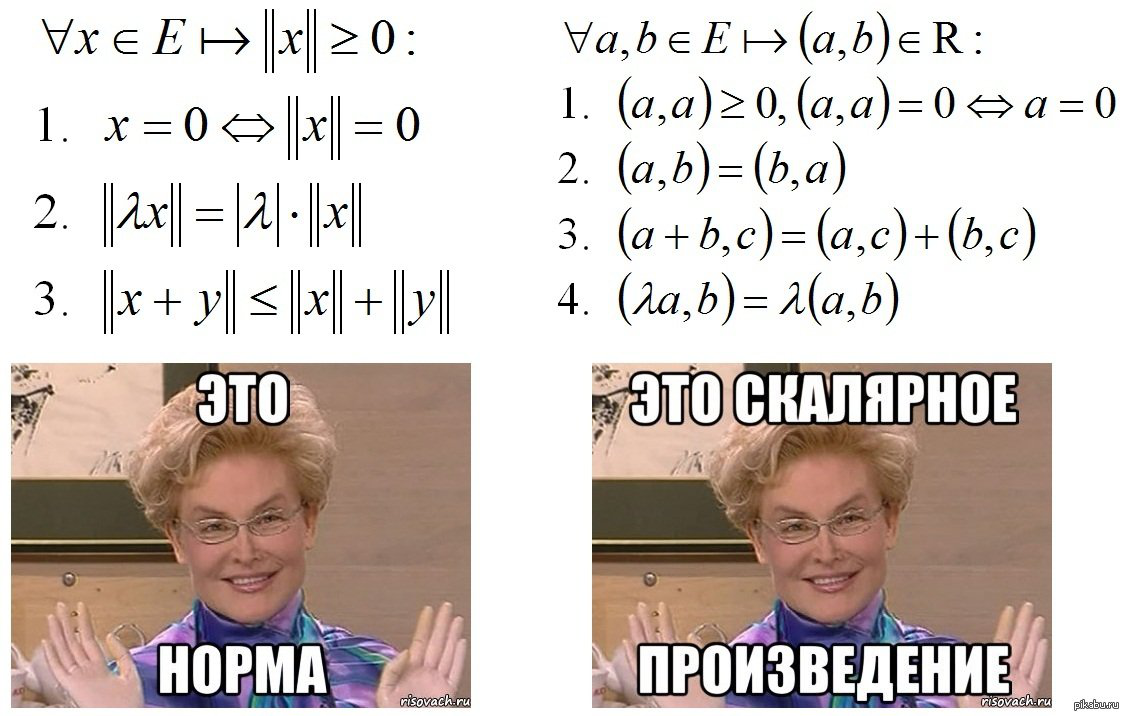

In [3]:
image = Image.open('./image.jpg')
image

# 1. "Median filter"

In [4]:
BLOCK_SIZE = 16

In [5]:
SOURCE_APPLY_MEDIAN_FILTER = SourceModule("""
__global__ void apply_median_filter(
    unsigned char *image,
    unsigned char *filtered_image,
    unsigned int height,
    unsigned int width,
    unsigned int kernel_size
) {
    unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < height && col < width) {
        int kernel_half = kernel_size / 2;
        unsigned char* values = new unsigned char[kernel_size * kernel_size];

        // collect window values
        for (int i = -kernel_half; i <= kernel_half; ++i) {
            for (int j = -kernel_half; j <= kernel_half; ++j) {
                unsigned int x = max(0, min(height - 1, row + i));
                unsigned int y = max(0, min(width - 1, col + j));

                values[(i + kernel_half) * kernel_size + (j + kernel_half)] = image[x * width + y];
            }
        }

        // sort window values
        for (unsigned int i = 0; i <= kernel_size * kernel_size / 2; ++i) {
            unsigned int pos = i;
            for (unsigned int j = i + 1; j < kernel_size * kernel_size; ++j) {
                if (values[pos] > values[j]) {
                    pos = j;
                }
            }
            unsigned char tmp = values[pos];
            values[pos] = values[i];
            values[i] = tmp;
        }

        // assign median window value to filtered image pixel
        filtered_image[row * width + col] = values[kernel_size * kernel_size / 2];
        delete[] values;
    }
}
""")

In [6]:
def median_filter_cuda(img, kernel_size):
    if kernel_size % 2 != 1:
        raise ValueError(
            "Currently implemented only for square kernels with odd dimensions."
        )

    height, width = img.shape[:2]

    dim_grid_x = math.ceil(height / BLOCK_SIZE)
    dim_grid_y = math.ceil(width / BLOCK_SIZE)

    apply_median_filter = SOURCE_APPLY_MEDIAN_FILTER.get_function(
        "apply_median_filter"
    )

    filtered_img = np.empty_like(img)
    for channel_idx in range(img.shape[2]):
        img_channel = img[:, :, channel_idx].copy()
        apply_median_filter(
            cuda.In(img_channel),
            cuda.Out(img_channel),
            np.uint32(height),
            np.uint32(width),
            np.uint32(kernel_size),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        filtered_img[:, :, channel_idx] = img_channel

    return filtered_img

In [7]:
def apply_filter(img, filter_fn):
    """Applies filter to image and returns filtered image."""
    img = np.array(img)
    start_time = time.time()
    result = filter_fn(img)
    filtered_img = Image.fromarray(result)
    print(f"Time: {time.time() - start_time:.4f} s.")

    return filtered_img

Time: 0.7940 s.


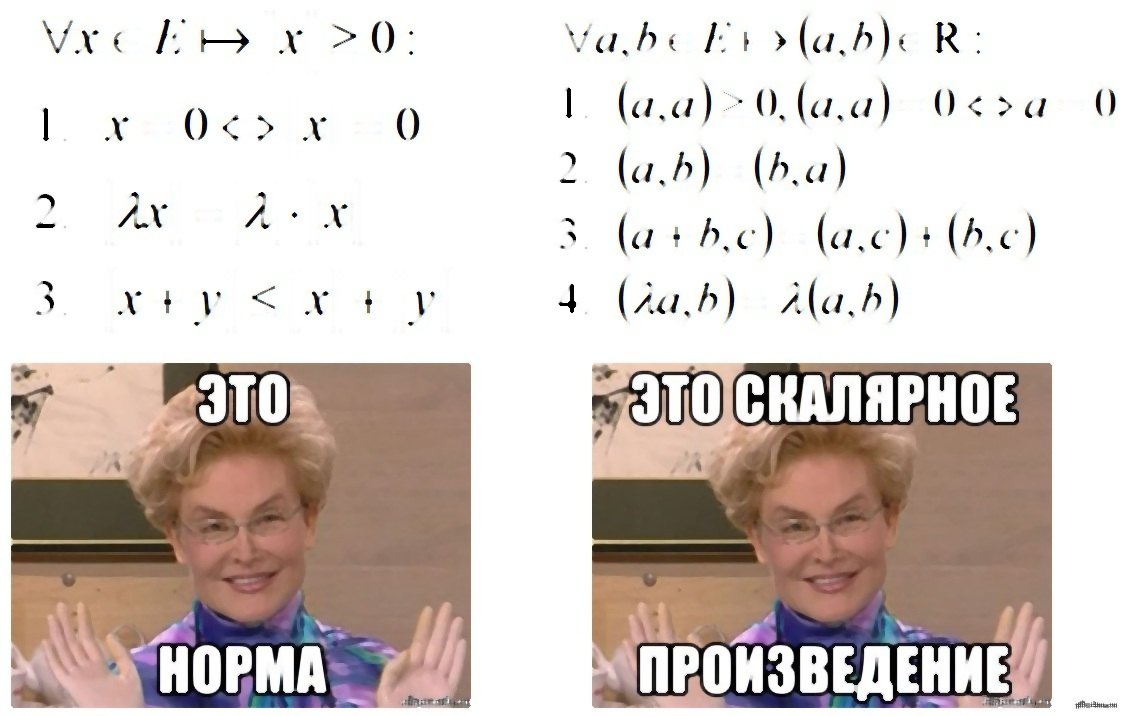

In [8]:
apply_filter(image, partial(median_filter_cuda, kernel_size=5))

Time: 1.5082 s.


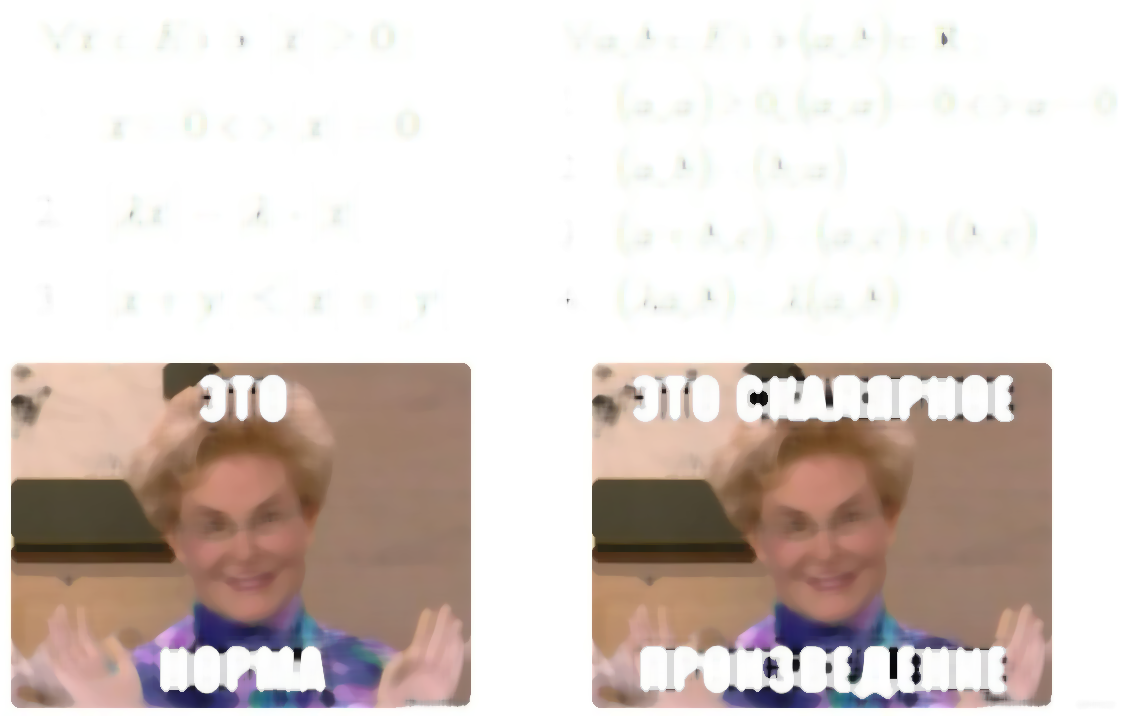

In [9]:
apply_filter(image, partial(median_filter_cuda, kernel_size=13))

# 2. Гистограмма картинки

In [10]:
SOURCE_GET_HISTOGRAM = SourceModule("""
__global__ void get_histogram(
      unsigned char *image,
      unsigned int height,
      unsigned int width,
      unsigned int *bins,
      unsigned int num_bins,
      unsigned int *hist
) {
    unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < height && col < width) {
        int value = image[col * width + row];
        for (int i = 0; i < num_bins; ++i) {
            if (value >= bins[i] && value < bins[i + 1]) {
                atomicAdd(&(hist[i]), 1);
            }
        }
    }
  }
  """)

In [11]:
CHANNEL_COLORS = {0: "r", 1: "g", 2: "b"}

In [12]:
def plot_histogram(img, num_bins: int) -> None:
    img = np.array(img)

    height, width = img.shape[:2]
    bins = np.linspace(0, 256, num_bins + 1, dtype=np.uint32)

    dim_grid_x = math.ceil(height / BLOCK_SIZE)
    dim_grid_y = math.ceil(width / BLOCK_SIZE)

    get_histogram = SOURCE_GET_HISTOGRAM.get_function("get_histogram")

    plt.figure(figsize=(16, 8))
    plt.grid()

    for channel_idx in range(img.shape[2]):
        img_channel = img[:, :, channel_idx].copy()
        hist = np.zeros(num_bins, dtype=np.uint32)
        get_histogram(
            cuda.In(img_channel),
            np.uint32(height),
            np.uint32(width),
            cuda.In(bins),
            np.uint32(num_bins),
            cuda.Out(hist),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        plt.plot(
            bins[:-1],
            hist,
            label=f"Channel {channel_idx}",
            color=CHANNEL_COLORS[channel_idx]
        )
    plt.legend(loc="best")

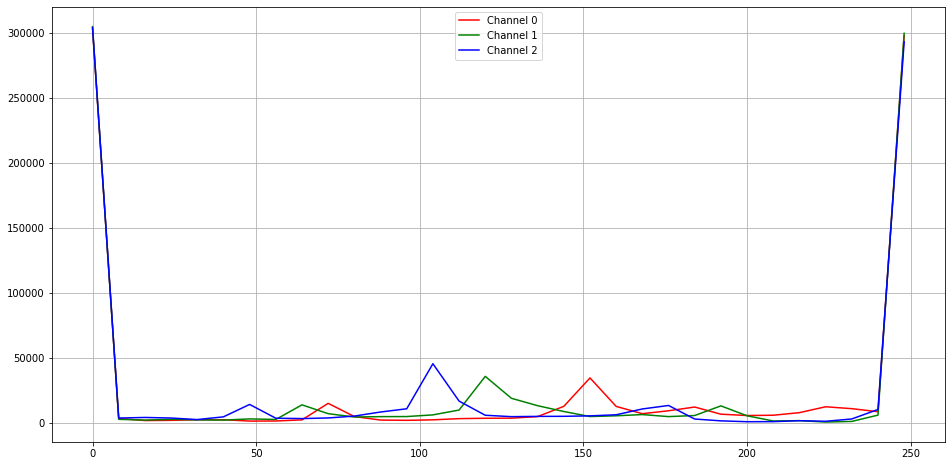

In [28]:
plot_histogram(image, num_bins=32)